In [1]:
import torch
from Interfaces import DKLasso
from scipy.io import loadmat

C:\Users\Yixiao\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
x = np.concatenate([x, np.random.randn(*x.shape)], axis=1)

In [2]:
data = torch.Tensor(loadmat('elevators.mat')['data'])
x = data[:, :-1]
torch.manual_seed(2345)
x = torch.cat([x, torch.randn(size = x.shape, dtype=x.dtype)], dim=1)
y = data[:, -1]
del data

In [3]:
x_mean = x.mean(0)
x_std = x.std(0)

y_mean = y.mean()
y_std = y.std()

In [4]:
x = (x - x_mean) / x_std
y = (y - y_mean) / y_std

In [5]:
# train_x = x[:15000, :]
train_x = x[:4100, :]
# x = x - x.min(0)[0]
# x = 2 * (x / x.max(0)[0]) - 1
# x = x - x.mean(0)
# x = x / x.std(0)
# train_y = y[:15000]
train_y = y[:4100]

test_x = x[15000:16599, :]
test_y = y[15000:16599]

# test_x = torch.FloatTensor(test_x)
# test_y = torch.FloatTensor(test_y)
del x, y

In [11]:
# %time
DKLassoObj = DKLasso(method="Regressor",
                     model_type="Exact",
                     kernel="Matern",
                    additive=False,
                    hidden_dims=(1000,500,50,5),
                    lambda_start=None,
                    lambda_max=float("inf"),
                    path_multiplier=(1.03,1.01),
                    gamma=1.0e-3,
                    M=10,
                    dropout=(0.3,),
                    grid_size=None,
                    lr=(1e-3, 1e-3),
                    n_epochs=(1500, 150),
                    patience=(40, 4),
                    offset=(100, 1),
                    training_batch_size=2048,
                    test_size=0.1,
                    device=None,
                    verbose=0,
                    random_state=12345,
                    torch_seed=123456)

%time path = DKLassoObj.train_path(x=train_x, y=train_y)


Initialized dense DKL model
152 epochs, train_loss (NMLL) 7.593e-01, test_loss (MSE) 1.695e-01, l2_reg 6.214e+01, l1_reg_skip 7.278e+00
CPU times: total: 2min 50s
Wall time: 3min 15s


In [6]:
# %time
DKLassoObj2 = DKLasso(method="Regressor",
                     model_type="Exact",
                     kernel="Matern",
                    additive=True,
                    hidden_dims=(1000,500,50,5),
                    lambda_start=None,
                    lambda_max=float("inf"),
                    path_multiplier=(1.03,1.01),
                    gamma=1.0e-3,
                    M=10,
                    dropout=(0.3,),
                    grid_size=None,
                    lr=(1e-3, 1e-3),
                    n_epochs=(1500, 150),
                    patience=(40, 4),
                    offset=(100, 1),
                    training_batch_size=2048,
                    test_size=0.1,
                    device=None,
                    verbose=0,
                    random_state=1234,
                    torch_seed=12345)

%time path2 = DKLassoObj2.train_path(x=train_x, y=train_y)


Initialized dense DKL model
232 epochs, train_loss (NMLL) 6.825e-01, test_loss (MSE) 2.107e-01, l2_reg 6.043e+01, l1_reg_skip 7.563e+00
CPU times: total: 3min 33s
Wall time: 3min 59s


In [ ]:
print(f"n_lambda  lambda  selected  trains_loss  test_loss\n")
n = 0
for p in path2[1:]:
    n += 1
    print(f"{n:2}         {p.lambda_:.3f}    {p.selected.sum().item():2}      {p.train_loss:.3f}        {p.test_loss:.3f}")

In [ ]:
print(f"n_lambda  lambda  selected  trains_loss  test_loss\n")
n = 0
for p in path[1:]:
    n += 1
    print(f"{n:2}         {p.lambda_:.3f}    {p.selected.sum().item():2}      {p.train_loss:.3f}        {p.test_loss:.3f}")

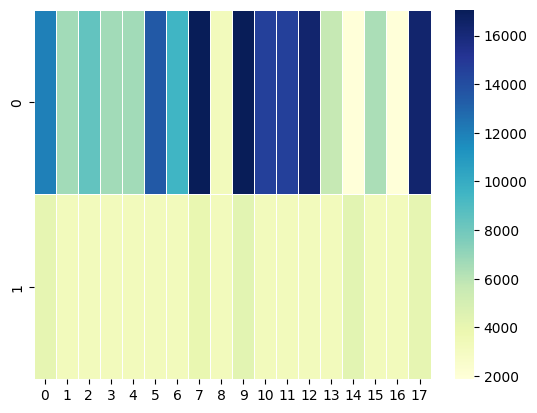

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

imp = DKLassoObj.feature_importances.reshape((2, 18))
imp -= imp.min()
imp /= imp.max()
ax = sns.heatmap(imp, linewidth=0.5, cmap="YlGnBu")
plt.show()

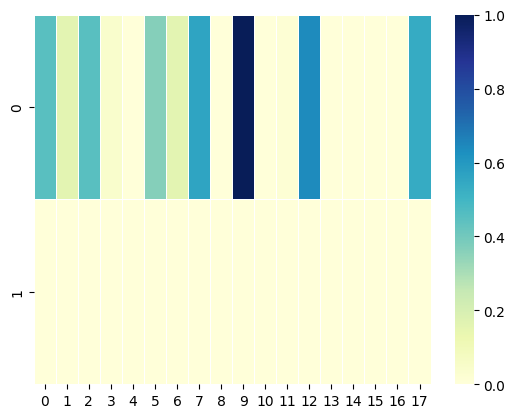

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

imp = DKLassoObj.feature_importances.reshape((2, 18))
imp -= imp.min()
imp /= imp.max()
ax = sns.heatmap(imp, linewidth=0.5, cmap="YlGnBu")
plt.show()

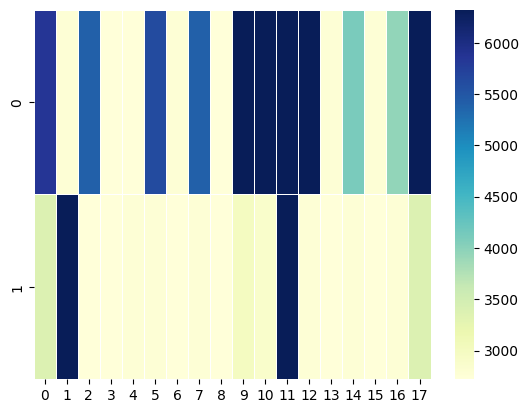

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

imp = DKLassoObj2.feature_importances.reshape((2, 18))
ax = sns.heatmap(imp, linewidth=0.5, cmap="YlGnBu")
plt.show()

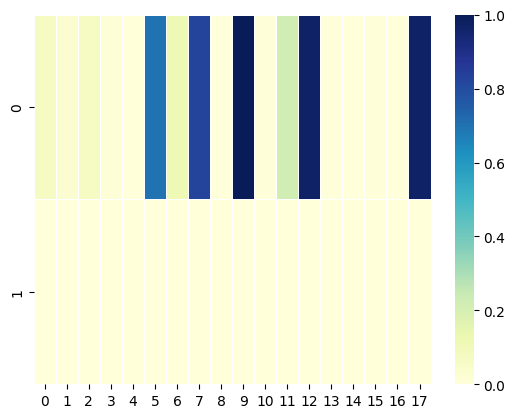

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

imp2 = DKLassoObj2.feature_importances.reshape((2, 18))
imp2 -= imp2.min()
imp2 /= imp2.max()
ax = sns.heatmap(imp2, linewidth=0.5, cmap="YlGnBu")
plt.show()

In [13]:
import gpytorch
import torch
import math

def cal_pred_error(path, DKLassoObj, x, y, type="MSLL"):
    model = DKLassoObj.model.to("cuda")
    test_x = x.to("cuda")
    test_y = y.to("cuda")
    
    selected = math.ceil(path[0].selected.sum().item()*1.05)
    model.load_state_dict(path[0].state_dict)
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(32):
        pred_dist = DKLassoObj.likelihood(model(test_x))
    if type == "MSLL":
        error = gpytorch.metrics.mean_standardized_log_loss(pred_dist, test_y).item()
    elif type == "MSE":
        error = gpytorch.metrics.mean_squared_error(pred_dist, test_y).item()
        
    num_selected = [selected]
    num_visited = [1]
    test_loss = [path[0].test_loss]
    best_error = [error]
    path_idx = [0]
    for i in range(1,len(path)):
        selected = path[i].selected.sum().item()
        if selected in num_selected:
            slt_idx = num_selected.index(selected)
            num_visited[slt_idx] += 1
            if path[i].test_loss < test_loss[slt_idx]:
                model.load_state_dict(path[i].state_dict)
                with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(32):
                    pred_dist = DKLassoObj.likelihood(model(test_x))
                if type == "MSLL":
                    error = gpytorch.metrics.mean_standardized_log_loss(pred_dist, test_y).item()
                elif type == "MSE":
                    error = gpytorch.metrics.mean_squared_error(pred_dist, test_y).item()
                best_error[slt_idx] = error
                path_idx[slt_idx] = i
        else:
            model.load_state_dict(path[i].state_dict)
            with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(32):
                pred_dist = DKLassoObj.likelihood(model(test_x))
            if type == "MSLL":
                error = gpytorch.metrics.mean_standardized_log_loss(pred_dist, test_y).item()
            elif type == "MSE":
                error = gpytorch.metrics.mean_squared_error(pred_dist, test_y).item()
                
            num_selected.append(selected)
            num_visited.append(1)
            test_loss.append(path[i].test_loss)
            best_error.append(error)
            path_idx.append(i)
            
        sort_idx = sorted(range(len(num_selected)), key=lambda k: num_selected[k], reverse=True)
        num_selected = [num_selected[k] for k in sort_idx]
        num_visited = [num_visited[k] for k in sort_idx]
        test_loss = [test_loss[k] for k in sort_idx]
        best_error = [best_error[k] for k in sort_idx]
        path_idx = [path_idx[k] for k in sort_idx]
        
    return num_selected, num_visited, test_loss, best_error, path_idx

In [14]:
selected, num_visited, test_loss, error, path_idx = cal_pred_error(path=path, DKLassoObj=DKLassoObj, x=test_x, y=test_y, type="MSLL")
#selected2, num_visited2, test_loss2, error2, path_idx2 = cal_pred_error(path=path2, DKLassoObj=DKLassoObj2, x=test_x, y=test_y, type="MSLL")

Text(0.5, 1.0, 'Mean Standardized Log Loss')

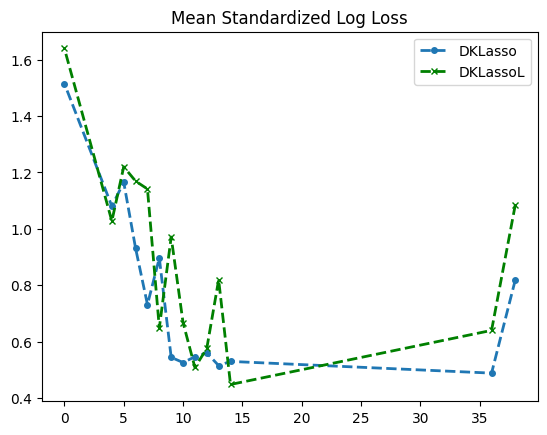

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
Non_additive, = ax.plot(selected, error, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='DKLasso')
Additive, = ax.plot(selected2, error2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="DKLassoL")
ax.legend(handles=[Non_additive, Additive])
# for i in range(len(num_visited)):
#     plt.text(selected[i], error[i]*1.01, num_visited[i])
# for i in range(len(num_visited2)):
#     plt.text(selected2[i], error2[i]*1.01, num_visited2[i])
plt.title("Mean Standardized Log Loss")
# plt.xticks(xi)

In [17]:
# selected, num_visited, test_loss, error, path_idx = cal_pred_error(path=path, DKLassoObj=DKLassoObj, x=test_x, y=test_y, type="MSLL")
selected2, num_visited2, test_loss2, error2, path_idx2 = cal_pred_error(path=path2, DKLassoObj=DKLassoObj2, x=test_x, y=test_y, type="MSLL")

Text(0.5, 1.0, 'Mean Standardized Log Loss')

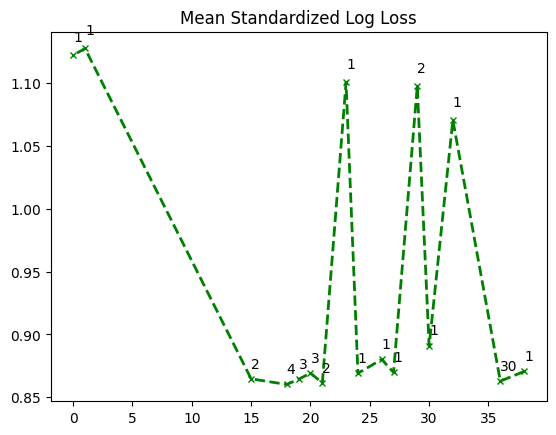

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
# Non_additive, = ax.plot(selected, error, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='Non-additive Kernel')
Additive, = ax.plot(selected2, error2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="Additive Kernel")
# ax.legend(handles=[Non_additive, Additive])
for i in range(len(num_visited2)):
    plt.text(selected2[i], error2[i]*1.01, num_visited2[i])
plt.title("Mean Standardized Log Loss")
# plt.xticks(xi)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
Non_additive, = ax.plot(selected, error, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='Non-additive Kernel')
Additive, = ax.plot(selected2, error2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="Additive Kernel")
ax.legend(handles=[Non_additive, Additive])
plt.title("Mean Standardized Log Loss")
# plt.xticks(xi)

In [21]:
# selected, error, path_idx = cal_pred_error(path=path, DKLassoObj=DKLassoObj, x=test_x, y=test_y, type="MSE")
selected2, test_loss2, error2, path_idx2 = cal_pred_error(path=path2, DKLassoObj=DKLassoObj2, x=test_x, y=test_y, type="MSE")

Text(0.5, 1.0, 'Mean Squared Error')

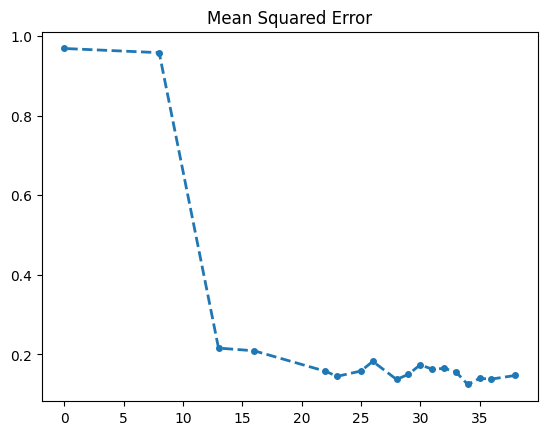

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
Non_additive, = ax.plot(selected, error, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='Non-additive Kernel')
# Additive, = ax.plot(selected2, error2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="Additive Kernel")
# ax.legend(handles=[Non_additive, Additive])
plt.title("Mean Squared Error")

Text(0.5, 1.0, 'Mean Squared Error')

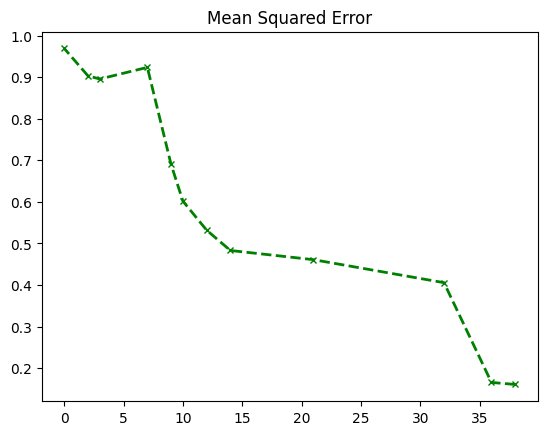

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
# Non_additive, = ax.plot(selected, error, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='Non-additive Kernel')
Additive, = ax.plot(selected2, error2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="Additive Kernel")
# ax.legend(handles=[Non_additive, Additive])
plt.title("Mean Squared Error")

In [129]:
def path_filter(path, thr=0.5):
    selected = []
    loss = []
    for p in path:
        selected.append(p.selected.sum().item())
        loss.append(p.test_loss)
        
    def indices(list, element):
        result = []
        offset = -1
        while True:
            try:
                offset = list.index(element, offset+1)
            except ValueError:
                return result
            result.append(offset)

    path_filt = []
    
    selected_now = path[0].selected.sum().item()
    positions = indices(selected, selected_now)
    sub_loss = [loss[pos] for pos in positions]
    loss_now = min(sub_loss)
    path_idx = loss.index(loss_now)
    path_filt.append(path[path_idx])
    
    selected_pre = selected_now
    loss_pre = loss_now
    
    for i in range(selected_now-1, -1, -1):
        if i in selected:
            selected_now = i
            positions = indices(selected, selected_now)
            sub_loss = [loss[pos] for pos in positions]
            loss_diff = [abs(s-loss_pre) for s in sub_loss]
            if min(loss_diff) < abs(loss_pre)*thr:
                # loss_now = sub_loss[loss_diff.index(min(loss_diff))]
                loss_now = min(sub_loss)
                path_idx = loss.index(loss_now)
                path_filt.append(path[path_idx])

                selected_pre = selected_now
                loss_pre = loss_now
            else:
                continue
        
    return path_filt

In [130]:
path_filt = path_filter(path, thr=0.5)
path_filt2 = path_filter(path2, thr=0.5)

selected = []
loss = []
for p in path_filt:
    selected.append(p.selected.sum().item())
    loss.append(p.test_loss)

selected2 = []
loss2 = []
for p in path_filt2:
    selected2.append(p.selected.sum().item())
    loss2.append(p.test_loss)

In [9]:
def find_best(path, train=True):
    selected = [path[0].selected.sum().item()]
    if train:
        loss = [path[0].train_loss]
    else:
        loss = [path[0].test_loss]
    for p in path[1:]:
        realtime_selected = p.selected.sum().item()
            
        # if (realtime_selected > selected[-1]) and ((realtime_selected-selected[-1])>(selected[-1]*0.25)):
        #     continue
        # elif (realtime_selected < selected[-1]) and ((selected[-1]-realtime_selected)>(selected[-1]*0.75)):
        #     continue
            
        if realtime_selected in selected:
            index = selected.index(realtime_selected)
            if train:
                if p.train_loss < loss[index]:
                    loss[index] = p.train_loss
            else:
                if p.test_loss < loss[index]:
                    loss[index] = p.test_loss
        else:
            selected.append(realtime_selected)
            loss.append(p.test_loss)
        sort_idx = sorted(range(len(selected)), key=lambda k: selected[k], reverse=True)
        selected = [selected[k] for k in sort_idx]
        loss = [loss[k] for k in sort_idx]
        
    return selected, loss

In [10]:
selected, loss = find_best(path, train=True)
selected2, loss2 = find_best(path2, train=True)

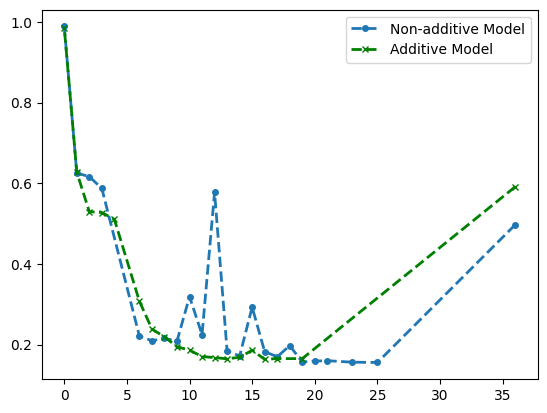

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
Non_additive, = ax.plot(selected, loss, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='Non-additive Model')
Additive, = ax.plot(selected2, loss2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="Additive Model")
ax.legend(handles=[Non_additive, Additive])
# plt.xticks(xi)

In [ ]:
print("selected  test_loss\n")
for i in range(len(selected2)):
    print(f"{selected2[i]:2}        {loss2[i]:.3f}")

In [12]:
selected, loss = find_best(path, train=False)
selected2, loss2 = find_best(path2, train=False)

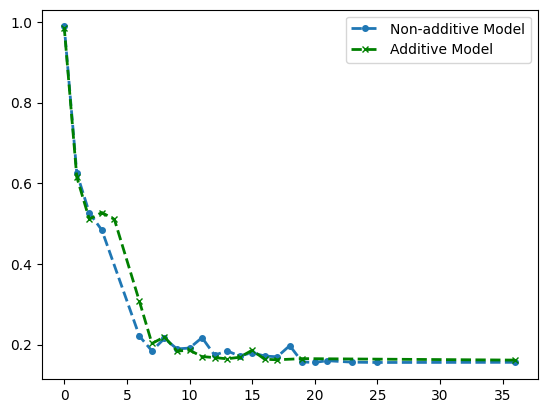

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# xi = list(range(19))
Non_additive, = ax.plot(selected, loss, marker='o', linestyle='dashed', linewidth=2, markersize=4, label='Non-additive Model')
Additive, = ax.plot(selected2, loss2, color='green', marker='x', linestyle='dashed', linewidth=2, markersize=4, label="Additive Model")
ax.legend(handles=[Non_additive, Additive])
# plt.xticks(xi)

In [12]:
def load(path_item, model_obj):
    if isinstance(path_item, HistoryItem):
        state_dict = path_item.state_dict
        # likelihood_state_dict = state_dict.likelihood_state_dict
    model_tmp = model_obj.model
    model_tmp.load_state_dict(state_dict)
    
    return model_tmp

In [19]:
model = load(path_results[47], SparseDKLModel)

In [313]:
model2, likelihood2 = load(path_results[4], NNdims=NNdims, train_x=train_x, train_y=train_y)

In [314]:
likelihood(model(train_x)).variance == likelihood2(model2(train_x)).variance

tensor([True, True, True,  ..., True, True, True])

In [ ]:
import numpy as np
from math import floor

train_n = int(floor(0.8 * len(x)))
train_set = np.random.choice(np.arange(0,len(x)), train_n, replace=False)
train_x = x[train_set, :]
train_y = y[train_set]

test_set = np.delete(np.arange(0,len(x)), train_set)
test_x = x[test_set, :]
test_y = y[test_set]

In [ ]:
import gpytorch
SparseDKLModel.model.eval()
SparseDKLModel.likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    pred = SparseDKLModel.likelihood(SparseDKLModel.model(test_x))

In [15]:
print('Test MAE: {}'.format(torch.mean(torch.abs(pred.mean - test_y))))

Test MAE: 1.0585298538208008


In [ ]:
from matplotlib import pyplot as plt

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = pred.confidence_region()
    # Plot training data as black stars
    ax.plot(test_x[:,0].numpy(), test_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x[:,0].numpy(), pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:,0].numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-2, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
model.feature_extractor.skip.weight.data[1]

In [ ]:
model.feature_extractor.layers[0].weight